Copyright (C) 2022 Glencoe Software, Inc. All Rights Reserved.

This program is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation; either version 2 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program; if not, write to the Free Software Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.

# Image Processing

* Connect to OMERO server
* List ROIs attached to the image
* Read pixels confined by `Analyze it!` ROI
* Find objects in the image
* Describe objects
* Create and upload OMERO ROIs
* Create and upload key-value pairs describing each ROI

### Connect to the OMERO server

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

from IPython.display import display, HTML

In [1]:
import gs_analytics

In [ ]:
from getpass import getpass
conn = gs_analytics.connect_to_omero(
    input("Username: "), getpass("OMERO Password: "), input("Host: "), int(input("Port: ")))

### Get list of ROIs and filter by name

In [5]:
image_id = input("Image Id: ")

roi_service = conn.getRoiService()
rois = roi_service.findByImage(int(image_id), None).rois

roi_name = input("ROI name: ")
print(f"Found {len(rois)} ROIs")
result = None
for roi in rois:
    if roi.getName() is None:
        continue
    if roi.getName().getValue().lower() == roi_name.lower():
        result = roi
        print(f"Found a name match for ROI id: {roi.id.val}")
        break

Image Id: 159804
ROI name: Analyse it!
Found  2  ROIs
Found a name match for ROI id:  419013


### Read pixels

Processing channel: DNA1
Reading tile: (724, 223, 1008, 841)


<IPython.core.display.Javascript object>


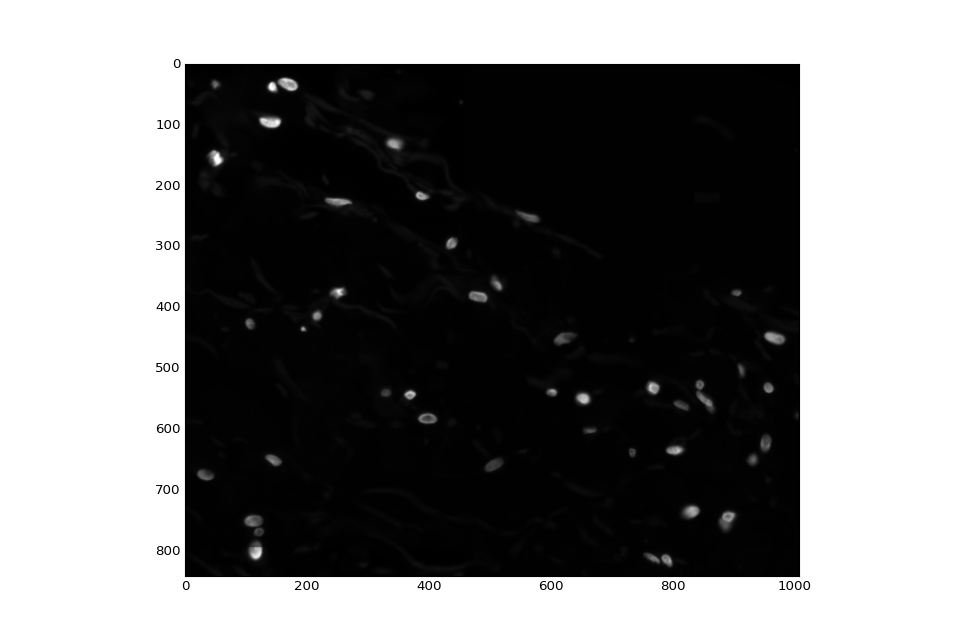

In [6]:
pixels, channel_label = gs_analytics.get_image_by_roi(conn, image_id, result)
imgplot = plt.imshow(pixels, cmap=plt.get_cmap('gray'))

### Preprocess pixels

In [7]:
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

In [8]:
thresh = threshold_otsu(pixels)
bw = closing(pixels > thresh, square(5))
cleared = clear_border(bw)
# imgplot2 = plt.imshow(bw, cmap=plt.get_cmap('gray'))
# label image regions
label_image = label(cleared)
image_label_overlay = label2rgb(label_image, image=pixels)

regions = regionprops(label_image)
regions_filtered = []
for region in regions:
    if region.area >= 100:
        regions_filtered.append(region)
print(f"Found {len(regions_filtered)} objects")

Found 33 objects


### Show regions

<IPython.core.display.Javascript object>


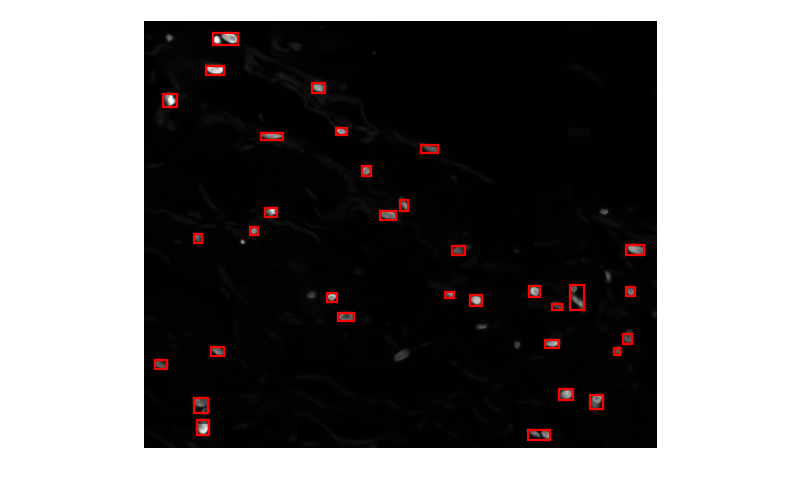

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(pixels, cmap=plt.get_cmap('gray'))
for region in regions_filtered:
    # draw rectangle around segmented coins
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                               fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Convert regions to ROIs

In [10]:
xShift = result.getShape(0).getX().getValue();
yShift = result.getShape(0).getY().getValue();
rois = gs_analytics.write_objects_to_rois(
    conn, image_id, regions_filtered,
    channel_label, xShift, yShift)
print(f"Saved {len(rois)} ROIs")

Saved  33  ROIs


### Add regions properties to ROIs

In [11]:
links = gs_analytics.save_map_annotations(conn, rois, regions_filtered)
print(f"Saved {len(links)} key-value pairs")    

Saved  33  key-value pairs


### Summarise regions

In [12]:
link = gs_analytics.summarise_regions(conn, result.id.val, regions_filtered)
print("Summary saved")

Computing average values for 33 regions
Attaching summary to ROI 419013
Summary saved
